In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv(r'data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
print('Shape:', df.shape)
print('Columns:', df.columns)
print('Missing values:', df.isnull().sum().sum())
print(df.describe())
print(df.info())

Shape: (918, 12)
Columns: Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')
Missing values: 0
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.49

In [4]:
df_processed = df.copy()
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, prefix=categorical_cols)

numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

scaler_onehot = StandardScaler()
df_encoded_scaled = df_encoded.copy()
df_encoded_scaled[numerical_cols] = scaler_onehot.fit_transform(df_encoded[numerical_cols])

for col in numerical_cols:
    mean_val = df_encoded_scaled[col].mean()
    std_val = df_encoded_scaled[col].std()

df_final = df_encoded_scaled
df_final['HeartDisease'] = df_final['HeartDisease'].astype(int)
print(df_final)

          Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
0   -1.433140   0.410909     0.825070          0  1.382928 -0.832432   
1   -0.478484   1.491752    -0.171961          0  0.754157  0.105664   
2   -1.751359  -0.129513     0.770188          0 -1.525138 -0.832432   
3   -0.584556   0.302825     0.139040          0 -1.132156  0.574711   
4    0.051881   0.951331    -0.034755          0 -0.581981 -0.832432   
..        ...        ...          ...        ...       ...       ...   
913 -0.902775  -1.210356     0.596393          0 -0.188999  0.293283   
914  1.536902   0.627078    -0.053049          1  0.164684  2.357094   
915  0.370100  -0.129513    -0.620168          0 -0.857069  0.293283   
916  0.370100  -0.129513     0.340275          0  1.461525 -0.832432   
917 -1.645286   0.302825    -0.217696          0  1.422226 -0.832432   

     HeartDisease  Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  \
0               0  False   True              False  ...  

In [5]:
X = df_final.drop(columns=['HeartDisease'])
y = df_final['HeartDisease']

print("Checking data types...")
print("Feature columns data types:")
print(X.dtypes)

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

if X.isnull().sum().sum() > 0:
    X = X.fillna(X.mean())

X_values = X.values.astype(np.float32)
y_values = y.values.astype(np.int64)

print(f"Features shape: {X_values.shape}")
print(f"Target shape: {y_values.shape}")
print(f"Features dtype: {X_values.dtype}")
print(f"Target dtype: {y_values.dtype}")
print(f"Number of features: {X_values.shape[1]}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_values, y_values, test_size=0.2, random_state=42, stratify=y_values
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"Training set: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Test set: {X_test_tensor.shape}, {y_test_tensor.shape}")

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print("✓ Data preparation complete!")


Checking data types...
Feature columns data types:
Age                  float64
RestingBP            float64
Cholesterol          float64
FastingBS              int64
MaxHR                float64
Oldpeak              float64
Sex_F                   bool
Sex_M                   bool
ChestPainType_ASY       bool
ChestPainType_ATA       bool
ChestPainType_NAP       bool
ChestPainType_TA        bool
RestingECG_LVH          bool
RestingECG_Normal       bool
RestingECG_ST           bool
ExerciseAngina_N        bool
ExerciseAngina_Y        bool
ST_Slope_Down           bool
ST_Slope_Flat           bool
ST_Slope_Up             bool
dtype: object
Features shape: (918, 20)
Target shape: (918,)
Features dtype: float32
Target dtype: int64
Number of features: 20
Training set: torch.Size([734, 20]), torch.Size([734])
Test set: torch.Size([184, 20]), torch.Size([184])
Batch size: 32
✓ Data preparation complete!


In [6]:
class HeartDiseaseNet(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], num_classes=2, dropout_rate=0.3):
        super(HeartDiseaseNet, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

input_size = X_train.shape[1]
model = HeartDiseaseNet(input_size=input_size)

print(f"\nModel Architecture:")
print(model)
print(f"Input features: {input_size}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

print("✓ Model initialization complete!")



Model Architecture:
HeartDiseaseNet(
  (network): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
)
Input features: 20
Total parameters: 13538
✓ Model initialization complete!


In [7]:

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        scheduler.step()

        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Evaluation phase
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for data, target in test_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()

        test_accuracy = 100 * test_correct / test_total

        # Store metrics
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
            print(f'  Test Acc: {test_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}')

    return train_losses, train_accuracies, test_accuracies

# Train the model
train_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100
)

print("✓ Training complete!")


Starting training for 100 epochs...
Epoch [10/100]
  Train Loss: 0.3124, Train Acc: 86.38%
  Test Acc: 89.13%, LR: 0.001000
Epoch [20/100]
  Train Loss: 0.2720, Train Acc: 88.83%
  Test Acc: 89.67%, LR: 0.001000
Epoch [30/100]
  Train Loss: 0.2589, Train Acc: 89.51%
  Test Acc: 89.67%, LR: 0.001000
Epoch [40/100]
  Train Loss: 0.2768, Train Acc: 88.56%
  Test Acc: 89.67%, LR: 0.001000
Epoch [50/100]
  Train Loss: 0.2169, Train Acc: 90.46%
  Test Acc: 88.59%, LR: 0.000500
Epoch [60/100]
  Train Loss: 0.2239, Train Acc: 90.19%
  Test Acc: 90.22%, LR: 0.000500
Epoch [70/100]
  Train Loss: 0.2246, Train Acc: 90.74%
  Test Acc: 90.22%, LR: 0.000500
Epoch [80/100]
  Train Loss: 0.2151, Train Acc: 89.24%
  Test Acc: 89.67%, LR: 0.000500
Epoch [90/100]
  Train Loss: 0.1900, Train Acc: 91.01%
  Test Acc: 90.22%, LR: 0.000500
Epoch [100/100]
  Train Loss: 0.2102, Train Acc: 91.01%
  Test Acc: 90.22%, LR: 0.000250
✓ Training complete!


In [8]:
def evaluate_model(model, test_loader, X_test_tensor, y_test_tensor):
    model.eval()
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return np.array(all_predictions), np.array(all_probabilities)

# Get predictions
y_pred, y_prob = evaluate_model(model, test_loader, X_test_tensor, y_test_tensor)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n" + "="*50)
print("PYTORCH MODEL EVALUATION RESULTS")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Best Test Accuracy during training: {max(test_accuracies):.2f}%")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Heart Disease', 'Heart Disease']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

torch.save(model.state_dict(), 'models/heart_disease_pytorch_model.pth')
print("\n✓ Model saved as 'heart_disease_pytorch_model.pth'")



PYTORCH MODEL EVALUATION RESULTS
Final Test Accuracy: 0.9022 (90.22%)
Best Test Accuracy during training: 90.76%

Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.89      0.89      0.89        82
   Heart Disease       0.91      0.91      0.91       102

        accuracy                           0.90       184
       macro avg       0.90      0.90      0.90       184
    weighted avg       0.90      0.90      0.90       184


Confusion Matrix:
[[73  9]
 [ 9 93]]

✓ Model saved as 'heart_disease_pytorch_model.pth'


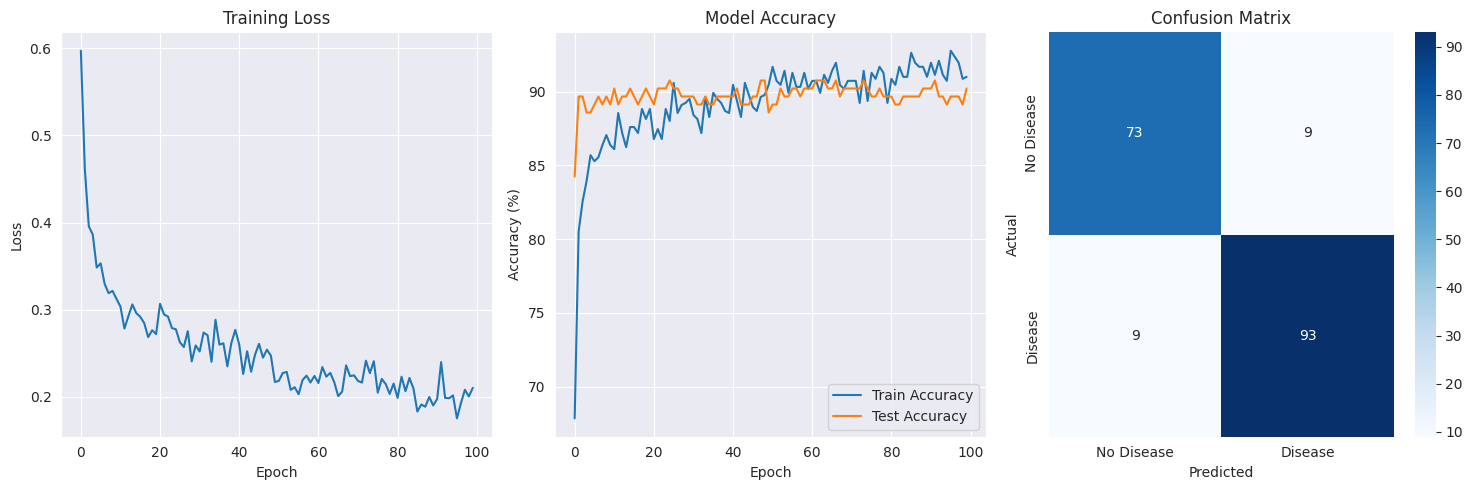

✓ Training visualization complete!


In [9]:

# Plot training history
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

print("✓ Training visualization complete!")
